In [1]:
import zipfile
import os

# Specify the path to the ZIP file
zip_file_path = 'cnn_dataset.zip'

# Specify the directory where you want to extract the contents of the ZIP file
extracted_dir_path = os.path.join(os.path.dirname(zip_file_path), 'cnn_dataset')

# Create the directory if it does not exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Print a message indicating that the extraction is complete
print("Extraction complete.")

Extraction complete.


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Define data augmentation
data_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root='cnn_dataset', transform=data_transform)


# Print dataset statistics
num_classes = len(dataset.classes)
print("Number of classes:", len(dataset.classes))
print("Class names:", dataset.classes)
print("Number of images:", len(dataset))

# Categorical conversion
dataset.targets = torch.tensor(dataset.targets)

# Data split
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print main statistics about the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of classes: 3
Class names: ['dogs', 'food', 'vehicles']
Number of images: 30000
Number of training samples: 21000
Number of validation samples: 4500
Number of testing samples: 4500


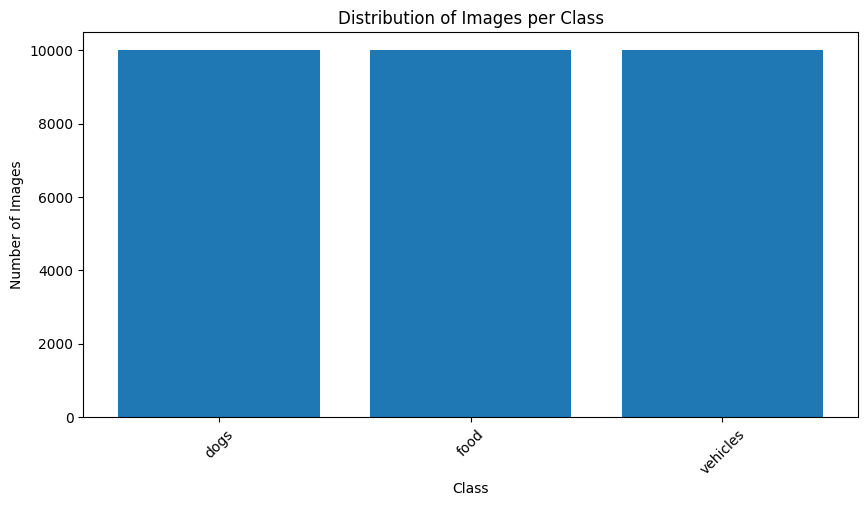

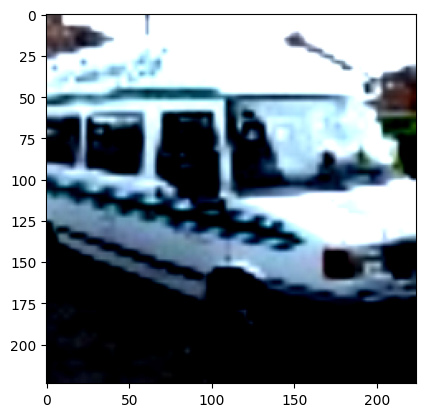

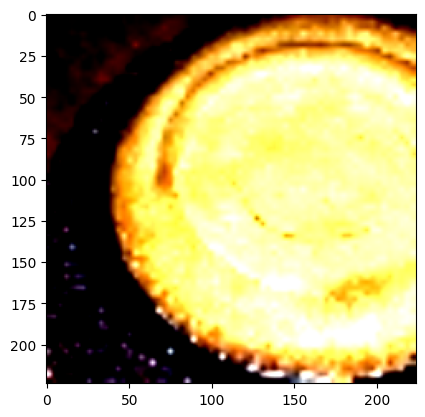

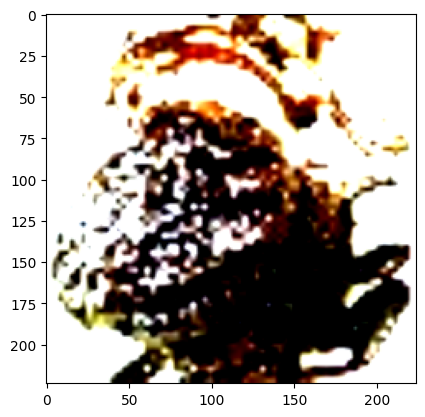

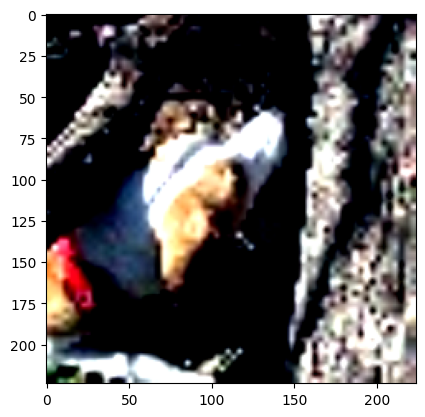

Labels: [2, 1, 1, 0]


In [3]:
# Visualization 1: Distribution of images per class
class_counts = [0] * num_classes
for _, label in dataset:
    class_counts[label] += 1

plt.figure(figsize=(10, 5))
plt.bar(dataset.classes, class_counts)
plt.title('Distribution of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

import torchvision.utils

# Visualization 2: Showing some sample images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display a few images from the batch
num_images_to_show = 4
for i in range(min(num_images_to_show, len(images))):
    imshow(torchvision.utils.make_grid(images[i]))

# Print corresponding labels
print(f"Labels: {labels[:num_images_to_show].tolist()}")


## 1 - Base Model

In [4]:
import torch.nn as nn

class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model
model = VGG13(num_classes)

# Print the model architecture
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.parallel import DataParallel

# Define optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.3, verbose=True)

import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

# Train the model
num_epochs = 3

train_accuracy_history = []
val_accuracy_history = []
train_loss_history = []
val_loss_history = []

start_time = time.time()
print_every = 100  # Print after every 100 images

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Print after every 100 images
        if batch_idx % print_every == 0:
            current_time = time.time()
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Batch {batch_idx}/{len(train_loader)}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_accuracy_history.append(val_accuracy)
    val_loss_history.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    # Adjust learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Testing loop
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader.dataset)
    print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}')


Epoch 1/3, Batch 100/657, Total images trained: 3200, Training Accuracy: 32.69%
Epoch 1/3, Batch 200/657, Total images trained: 6400, Training Accuracy: 32.50%
Epoch 1/3, Batch 300/657, Total images trained: 9600, Training Accuracy: 32.60%
Epoch 1/3, Batch 400/657, Total images trained: 12800, Training Accuracy: 35.05%
Epoch 1/3, Batch 500/657, Total images trained: 16000, Training Accuracy: 38.56%
Epoch 1/3, Batch 600/657, Total images trained: 19200, Training Accuracy: 43.07%
Epoch 1/3, Training Loss: 1.0601, Training Accuracy: 45.37%, Validation Loss: 0.7040, Validation Accuracy: 69.62%
Test Accuracy: 68.40%
Test Loss: 0.7207
Epoch 2/3, Batch 100/657, Total images trained: 3200, Training Accuracy: 70.03%
Epoch 2/3, Batch 200/657, Total images trained: 6400, Training Accuracy: 71.53%
Epoch 2/3, Batch 300/657, Total images trained: 9600, Training Accuracy: 72.22%
Epoch 2/3, Batch 400/657, Total images trained: 12800, Training Accuracy: 73.06%
Epoch 2/3, Batch 500/657, Total images tra

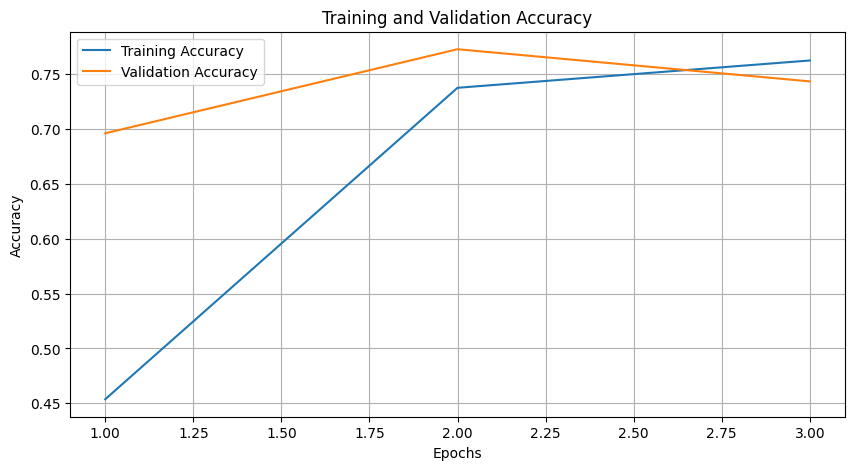

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Analyze the training process and collect relevant metrics
# This part is already implemented in the training loop, so we just need to collect the data.

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

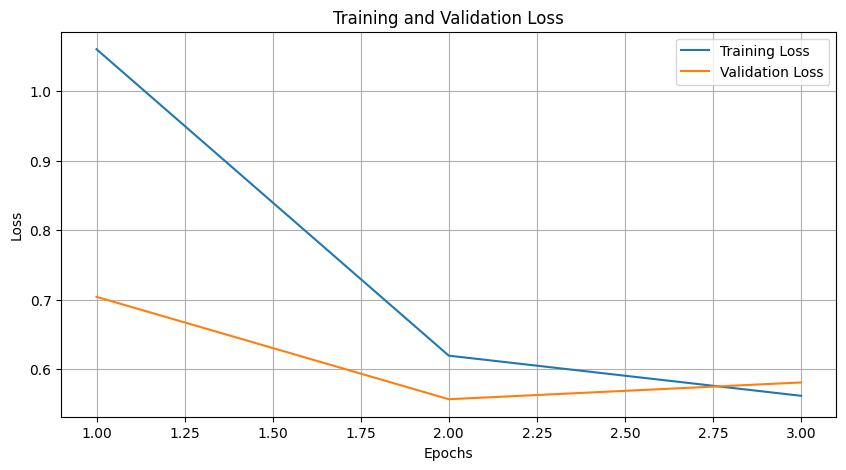

In [7]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Testing loop
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score with zero_division parameter
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='weighted', zero_division=1
)

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Confusion Matrix:
[[ 663  709   88]
 [  69 1359   63]
 [  65  146 1338]]
Precision: 0.7826
Recall: 0.7467
F1 Score: 0.7369


## 2 - Base model + L1 weight decay + Dropout layer

In [ ]:
import torch.nn as nn

class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model
model = VGG13(num_classes)

# Print the model architecture
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.parallel import DataParallel

# Define optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.3, verbose=True)

import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

# Train the model
num_epochs = 4

train_accuracy_history = []
val_accuracy_history = []
train_loss_history = []
val_loss_history = []

start_time = time.time()
print_every = 100  # Print after every 100 images

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Print after every 100 images
        if batch_idx % print_every == 0:
            current_time = time.time()
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Batch {batch_idx}/{len(train_loader)}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_accuracy_history.append(val_accuracy)
    val_loss_history.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    # Adjust learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Testing loop
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader.dataset)
    print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}')


Epoch 1/4, Batch 100/657, Total images trained: 3200, Training Accuracy: 51.69%
Epoch 1/4, Batch 200/657, Total images trained: 6400, Training Accuracy: 56.92%
Epoch 1/4, Batch 300/657, Total images trained: 9600, Training Accuracy: 60.01%
Epoch 1/4, Batch 400/657, Total images trained: 12800, Training Accuracy: 61.87%
Epoch 1/4, Batch 500/657, Total images trained: 16000, Training Accuracy: 63.71%
Epoch 1/4, Batch 600/657, Total images trained: 19200, Training Accuracy: 65.22%
Epoch 1/4, Training Loss: 0.7547, Training Accuracy: 66.13%, Validation Loss: 0.5431, Validation Accuracy: 78.09%
Test Accuracy: 79.42%
Test Loss: 0.5229
Epoch 2/4, Batch 100/657, Total images trained: 3200, Training Accuracy: 75.59%
Epoch 2/4, Batch 200/657, Total images trained: 6400, Training Accuracy: 76.77%
Epoch 2/4, Batch 300/657, Total images trained: 9600, Training Accuracy: 76.62%
Epoch 2/4, Batch 400/657, Total images trained: 12800, Training Accuracy: 77.20%
Epoch 2/4, Batch 500/657, Total images tra

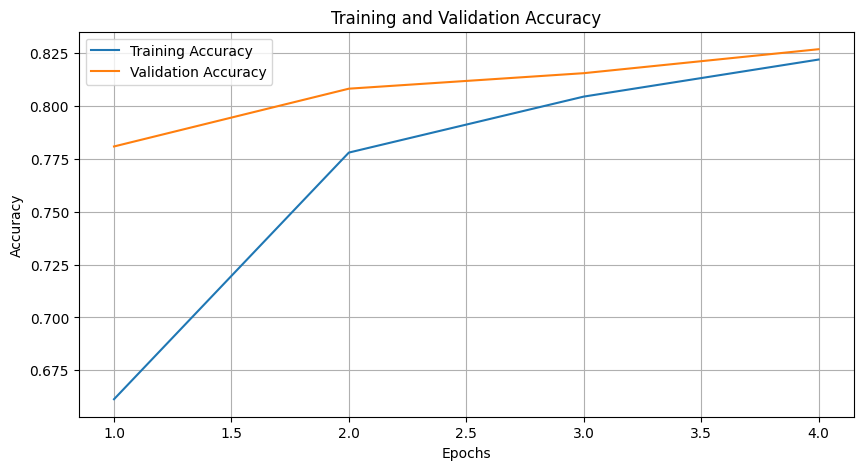

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

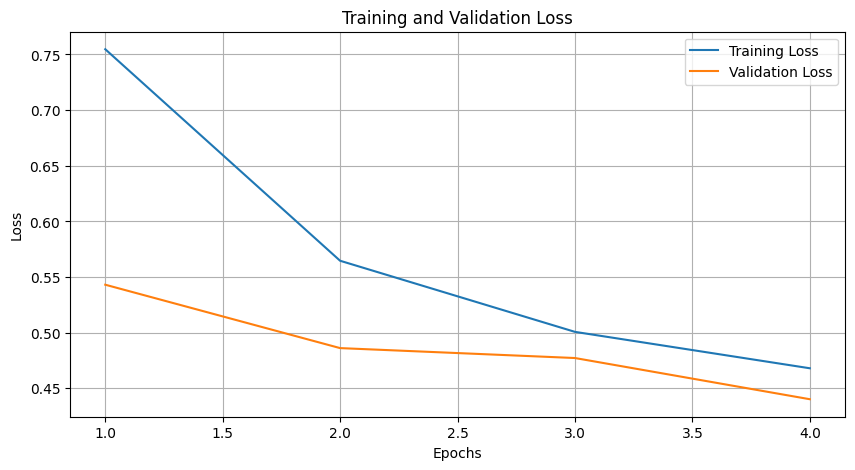

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Testing loop
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score with zero_division parameter
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='weighted', zero_division=1
)

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Confusion Matrix:
[[1022  391   79]
 [ 106 1343   29]
 [  93   99 1338]]
Precision: 0.8328
Recall: 0.8229
F1 Score: 0.8220


## 3 - Best model (Dropout layer, Data augmentation, Early stopping)

In [ ]:
import torch.nn as nn

class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model
model = VGG13(num_classes)

# Print the model architecture
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torch.nn.parallel import DataParallel

# Define data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply augmentation to the training set
train_dataset.dataset.transform = train_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

# Define optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.3, verbose=True)

import time

# Train the model
num_epochs = 4
best_val_loss = float('inf')
patience = 0

train_accuracy_history = []
val_accuracy_history = []
train_loss_history = []
val_loss_history = []

start_time = time.time()
print_every = 100  # Print after every 100 images

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Print after every 100 images
        if batch_idx % print_every == 0:
            current_time = time.time()
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Batch {batch_idx}/{len(train_loader)}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_accuracy_history.append(val_accuracy)
    val_loss_history.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
    else:
        patience += 1
        if patience > 5:  # If validation loss doesn't improve for 5 epochs, stop training
            print("Early stopping.")
            break

    # Adjust learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Testing loop
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader.dataset)
    print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}')

Epoch 1/4, Batch 100/657, Total images trained: 3200, Training Accuracy: 81.00%
Epoch 1/4, Batch 200/657, Total images trained: 6400, Training Accuracy: 81.20%
Epoch 1/4, Batch 300/657, Total images trained: 9600, Training Accuracy: 81.07%
Epoch 1/4, Batch 400/657, Total images trained: 12800, Training Accuracy: 81.03%
Epoch 1/4, Batch 500/657, Total images trained: 16000, Training Accuracy: 80.89%
Epoch 1/4, Batch 600/657, Total images trained: 19200, Training Accuracy: 80.93%
Epoch 1/4, Training Loss: 0.5043, Training Accuracy: 80.88%, Validation Loss: 0.5058, Validation Accuracy: 80.49%
Test Accuracy: 81.22%
Test Loss: 0.4868
Epoch 2/4, Batch 100/657, Total images trained: 3200, Training Accuracy: 81.50%
Epoch 2/4, Batch 200/657, Total images trained: 6400, Training Accuracy: 81.11%
Epoch 2/4, Batch 300/657, Total images trained: 9600, Training Accuracy: 80.93%
Epoch 2/4, Batch 400/657, Total images trained: 12800, Training Accuracy: 81.10%
Epoch 2/4, Batch 500/657, Total images tra

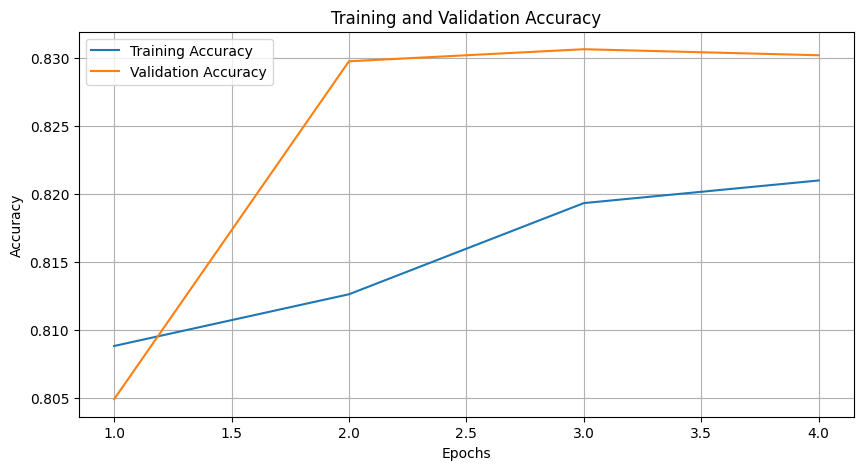

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

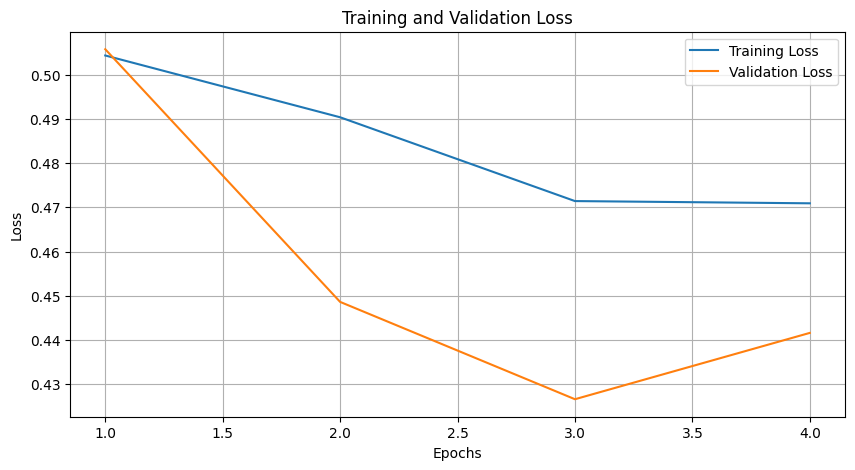

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Testing loop
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score with zero_division parameter
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='weighted', zero_division=1
)

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Confusion Matrix:
[[1282  157   53]
 [ 209 1252   17]
 [ 218  121 1191]]
Precision: 0.8386
Recall: 0.8278
F1 Score: 0.8292


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'best_model.pth')